# Some exploration of methods

In [2]:
# Load libraries and data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection  import cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from xgboost import XGBRegressor
import pickle



In [29]:
# Prep data for XGBoost
mass_residuals = pd.read_csv('../data/mass_residuals_data.csv')

SNP_data = mass_residuals.iloc[:,7:]
SNP_data.fillna(0)
Y = mass_residuals.ID
X_train_val, X_test, y_train_val, y_test = train_test_split(SNP_data, Y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

In [30]:
# hyperparameter tuning by baeysian optimization
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

space = {
    "max_depth": hp.choice("max_depth", range(1, 20)),
    "eta": hp.loguniform("eta", -5, -2),
    "subsample": hp.quniform("subsample", 0.5, 1, 0.05),
    "n_estimators": hp.choice("n_estimators", range(20, 205, 5)),
    "colsample_bytree": hp.quniform("colsample_bytree", 0.5, 1, 0.05),
}

def objective(params):
    xgb_r = XGBRegressor(**params)
    xgb_r.fit(X_train, y_train)
    y_pred = xgb_r.predict(X_val)  
    score = mean_squared_error(y_val, y_pred, squared=False)
    return {"loss": score, "status": STATUS_OK}

trials = Trials()  
best = fmin(objective, space, algo=tpe.suggest, max_evals=100, trials=trials)
print("Best Hyperparamters:",best)

100%|██████████| 100/100 [3:10:40<00:00, 114.41s/trial, best loss: 1.084202264642221] 
Best Hyperparamters: {'colsample_bytree': 0.7000000000000001, 'eta': 0.014921452492714465, 'max_depth': 11, 'n_estimators': 31, 'subsample': 0.7000000000000001}


In [31]:
final_xgb = XGBRegressor(**best)
final_xgb.fit(X_train_val, y_train_val)
y_pred = final_xgb.predict(X_test)
score = mean_squared_error(y_test, y_pred, squared=False)
print("Final RMSE:",score)

Final RMSE: 1.1949465525539724


In [ ]:
pickle.dump(final_xgb, open("../models/xgb_bayesoptim_noselection.pkl", "wb"))

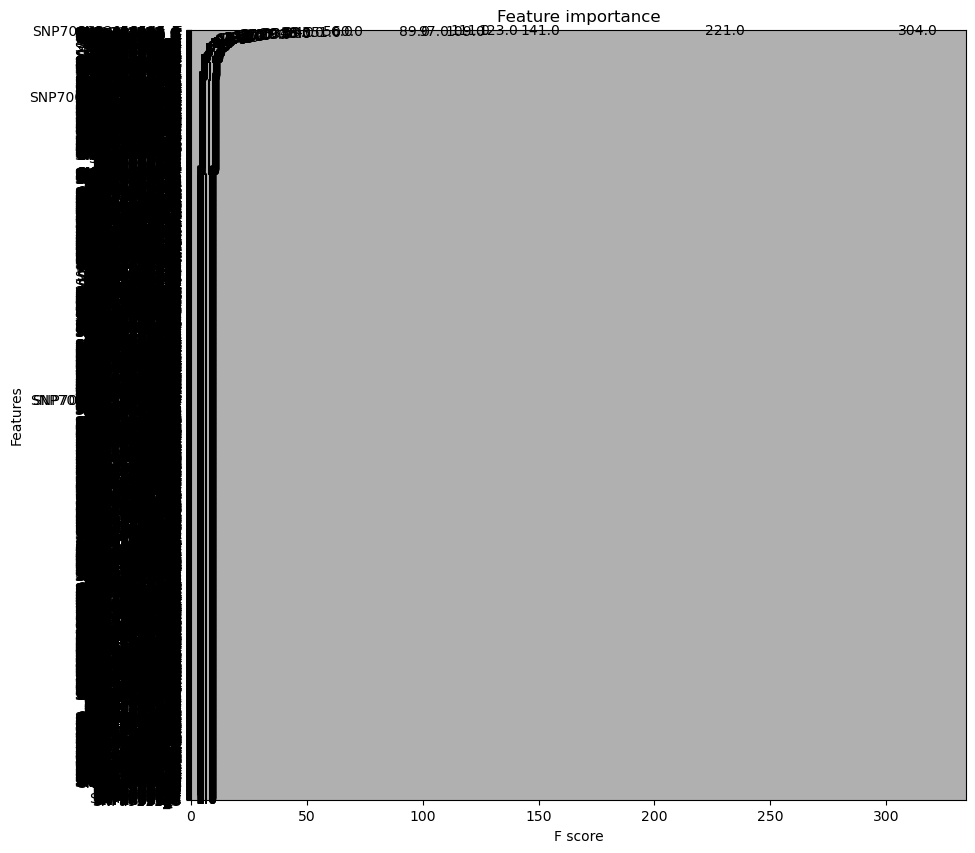

In [4]:
# Plot feature importance
final_xgb = pickle.load(open("../models/xgb_bayesoptim_noselection.pkl", "rb"))
fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(final_xgb, ax=ax)
#plt.savefig('../figures/xgb_bayesoptim_noselection.png')
plt.show()
